In [1]:
%matplotlib inline
import pylab
import numpy as np
import nengo

In [9]:
class RegularSpiking(object):
    def __init__(self, size, dt=0.001):
        self.state = np.zeros(size)
        self.threshold = 1.0 / dt
        self.output = np.zeros(size)
    def __call__(self, t, x):
        self.output[:] = 0
        self.state += x
        spikes = np.where(self.state > self.threshold)
        self.output[spikes] = self.threshold
        self.state -= self.output
        return self.output

In [30]:
class PoissonSpiking(object):
    def __init__(self, size, seed, dt=0.001):
        self.rng = np.random.RandomState(seed=seed)
        self.dt = dt
        self.value = 1.0 / dt
        self.size = size
        self.output = np.zeros(size)
    def __call__(self, t, x):
        self.output[:] = 0
        p = 1.0 - np.exp(-x*self.dt)
        self.output[p>self.rng.rand(self.size)] = self.value
        return self.output

In [31]:
model = nengo.Network()
with model:
    freq=10
    stim = nengo.Node(lambda t: np.sin(t*np.pi*2*freq))
    ens = nengo.Ensemble(n_neurons=5, dimensions=1, neuron_type=nengo.LIFRate(), seed=1)
    nengo.Connection(stim, ens, synapse=None)
    
    regular_spikes = nengo.Node(RegularSpiking(ens.n_neurons), size_in=ens.n_neurons)
    nengo.Connection(ens.neurons, regular_spikes, synapse=None)

    poisson_spikes = nengo.Node(PoissonSpiking(ens.n_neurons, seed=1), size_in=ens.n_neurons)
    nengo.Connection(ens.neurons, poisson_spikes, synapse=None)
    
    p_rate = nengo.Probe(ens.neurons)
    p_regular = nengo.Probe(regular_spikes)
    p_poisson = nengo.Probe(poisson_spikes)
sim = nengo.Simulator(model)
sim.run(0.1)

Simulation finished in 0:00:01.                                                 


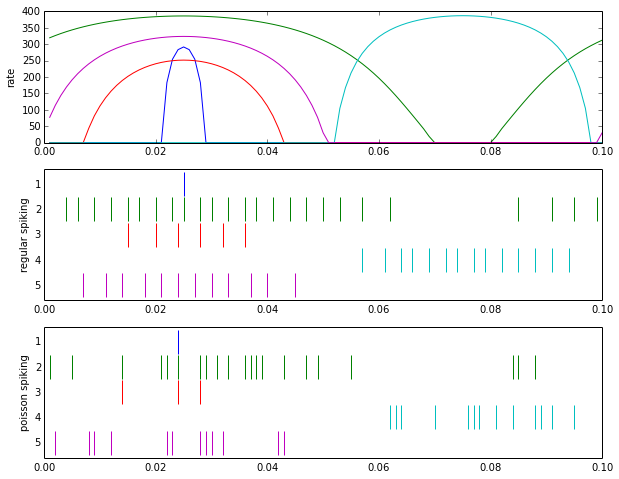

In [34]:
pylab.figure(figsize=(10,8))

pylab.subplot(3,1,1)
pylab.plot(sim.trange(), sim.data[p_rate])
pylab.xlim(0, sim.time)
pylab.ylabel('rate')

pylab.subplot(3,1,2)
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_regular])
pylab.xlim(0, sim.time)
pylab.ylabel('regular spiking')

pylab.subplot(3,1,3)
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p_poisson])
pylab.xlim(0, sim.time)
pylab.ylabel('poisson spiking')



pylab.show()